In [1]:
from flowjax.train import fit_to_data
from flowjax.train.losses import ContrastiveLoss
from flowjax.flows import masked_autoregressive_flow as MaskedAutoregressiveFlow
from flowjax.distributions import Normal, Laplace
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from jax import vmap
import pandas as pd
from flowjax.train.losses import MaximumLikelihoodLoss
from flowjax.bijections import Affine, Invert
from jax import vmap
import jax

In [2]:
#observed data
filename = "../../simulation/observed_data/dummy_x_o.csv"
x_o = pd.read_csv(filename)
#simulated data
filename2 = "../../simulation/output/round_1_point_mu/summary_stats_r1.csv"
x = pd.read_csv(filename2)

In [3]:
to_drop = [ #correlation >0.99
    "diversity_domestic",
    "relatedness_domestic_captive",
    "y2_domestic_captive",
    "segregating_sites_captive",
    ### outlier method >1
    'segregating_sites_domestic',
    'divergence_domestic_scot',
    'y3_domestic_scot_captive',
    'pc2_median_domestic',
    'pc2_median_scot',
    'pc1_iqr_domestic',
    'pc2_iqr_domestic',
    'pc1_dist_domestic_captive',
    'pc2_dist_domestic_scot',
    'pc2_dist_domestic_captive',
    ### outlier method >0.9
    'y2_domestic_scot',
    'pc2_dist_scot_captive'
          ]

In [ ]:
### for dummy point data
to_drop = [
    "diversity_domestic",
    "relatedness_domestic_captive",
    "y2_domestic_captive",
    "relatedness_domestic_captive",
    'segregating_sites_domestic',
    'tajimas_d_domestic',
    'tajimas_d_captive',
    'pc2_median_captive'
          ]

In [4]:
combined_x = pd.concat([x, x_o], ignore_index=True)
combined_x = combined_x.drop(columns=to_drop)
stats = combined_x.columns
combined_x = combined_x.to_numpy(dtype=np.float32)
np.shape(combined_x)

(10001, 41)

In [5]:
preprocess_x = Affine(-combined_x.mean(axis=0)/combined_x.std(axis=0), 1/combined_x.std(axis=0))

In [6]:
num = np.shape(x)[0]
print("combined_x shape", np.shape(combined_x))
combined_x_t = jax.vmap(preprocess_x.transform)(combined_x)
x_t = np.float32(combined_x_t[0:num])
x_o_t = np.float32(combined_x_t[num])
x_o_t = np.reshape(x_o_t, (1,-1))
print("x_t shape", np.shape(x_t))
print("x_o_t shape", np.shape(x_o_t))

combined_x shape (10001, 41)
x_t shape (10000, 41)
x_o_t shape (1, 41)


In [7]:
key, subkey = jr.split(jr.PRNGKey(2))
#define prior
n_summaries = np.shape(x_t)[1]
print("n_summaries", n_summaries)
unbounded_prior = Normal(jnp.zeros((n_summaries,)))

n_summaries 41


In [8]:
flow = MaskedAutoregressiveFlow(
    subkey,
    base_dist=Normal(jnp.zeros((n_summaries,))),
)

In [16]:
import optax
optimizer = optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(1e-4),
    )

In [17]:
loss_fn = MaximumLikelihoodLoss()

In [18]:

fitted_flow, losses_r = fit_to_data(
    key=subkey,
    dist=flow,
    loss_fn=loss_fn,
    x=x_t,
    optimizer = optimizer,
    max_epochs=1500,
    batch_size = 100,
    max_patience = 30
)

 69%|██████▉   | 1039/1500 [02:20<01:02,  7.41it/s, train=-71.5, val=-68.6 (Max patience reached)]


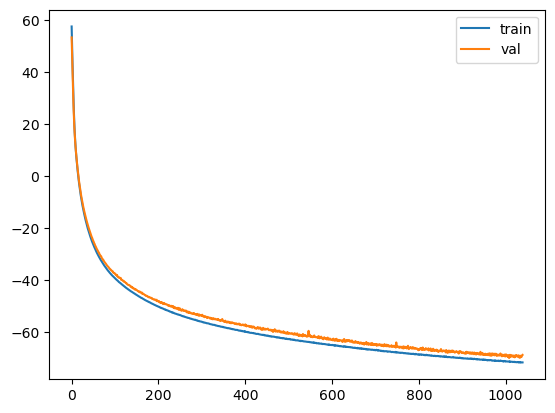

In [19]:
for k, v in losses_r.items():
    plt.plot(v, label=k)
plt.legend()

In [20]:
posterior = fitted_flow
posterior.log_prob(x_o_t)

Array([96.49739], dtype=float32)

round 1: Array([-2.75994e+08], dtype=float32)
round 2: 

#### Stat + error method

In [21]:
from flowjax.experimental.numpyro import sample


def model(obs=None):  # This is a numpyro probabilistic program
    noise_prior = Laplace(jnp.zeros((n_summaries, )), 1)
    error = sample("noise", noise_prior)
    denoised_obs = obs - error
    sample("x", flow, obs=denoised_obs)

In [22]:
from numpyro.infer import MCMC, NUTS
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=5000)
key, subkey = jr.split(key)
mcmc.run(subkey, obs=x_o_t)

sample: 100%|██████████| 6000/6000 [00:11<00:00, 542.12it/s, 31 steps of size 1.49e-01. acc. prob=0.83]


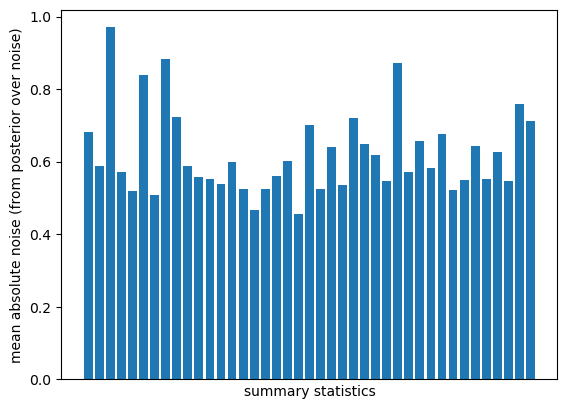

In [23]:
inferred_errors = mcmc.get_samples()["noise"]

mean_abs_error = jnp.abs(inferred_errors).mean(axis=0)
plt.bar(x=[f"s{i}" for i in range(n_summaries)], height=mean_abs_error)
plt.ylabel("mean absolute noise (from posterior over noise)")
plt.xlabel("summary statistics")
plt.xticks([])
#plt.savefig("outliers.png", dpi=600)
plt.show()

In [24]:
error = mean_abs_error.tolist()
error_dict = dict(zip(stats, error))

In [25]:
misspecified = {k: v for k, v in error_dict.items() if v > 0.8
               }
misspecified

{'segregating_sites_domestic': 0.9703755378723145,
 'tajimas_d_domestic': 0.8384945392608643,
 'tajimas_d_captive': 0.882193922996521,
 'pc2_median_captive': 0.8722909688949585}

In [26]:
misspecified.keys()

dict_keys(['segregating_sites_domestic', 'tajimas_d_domestic', 'tajimas_d_captive', 'pc2_median_captive'])

In [ ]:
# iter 1 (>1)
{'segregating_sites_domestic': 2.6293013095855713,
 'divergence_domestic_scot': 1.0941779613494873,
 'y3_domestic_scot_captive': 1.138970136642456,
 'pc2_median_domestic': 5.104488849639893,
 'pc2_median_scot': 1.2560690641403198,
 'pc1_iqr_domestic': 84.52836608886719,
 'pc2_iqr_domestic': 37.193138122558594,
 'pc1_dist_domestic_captive': 1.1826246976852417,
 'pc2_dist_domestic_scot': 3.8781538009643555,
 'pc2_dist_domestic_captive': 2.9655535221099854}